In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as K
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-04-13 19:28:48.865508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading The Data

In [2]:
with h5py.File("info/data/output_signal.h5", "r") as file:
    signal_data = file["events"][:]

with h5py.File("info/data/output_bg.h5", "r") as file:
    bg_data = file["events"][:]


len(signal_data) == 265525 , len(bg_data) == 232503 ## doesnt match the md file

(False, True)

In [3]:
bg_data.dtype

dtype([('jet_1_pt', '<f4'), ('jet_2_pt', '<f4'), ('jet_3_pt', '<f4'), ('jet_1_eta', '<f4'), ('jet_2_eta', '<f4'), ('jet_3_eta', '<f4'), ('jet_1_twb', 'u1'), ('jet_2_twb', 'u1'), ('jet_3_twb', 'u1'), ('bjet_1_pt', '<f4'), ('lep_1_pt', '<f4'), ('lep_2_pt', '<f4'), ('lep_3_pt', '<f4'), ('n_jets', 'u1'), ('n_bjets', 'u1'), ('n_leptons', 'u1'), ('met_met', '<f4'), ('H_T', '<f4')])

# Subset of the Data (my addition)

In [4]:
signal = pd.DataFrame(signal_data)
background = pd.DataFrame(bg_data)
df = pd.concat([signal, background])
df = df.reset_index()
labels = np.concatenate([np.ones(signal.shape[0]), np.zeros(background.shape[0])])
labels = pd.DataFrame({'ttZ': labels})
df = df.join(labels)
df.shape

(741538, 20)

In [5]:
# Shuffle the dataset
df_shuffled = df.sample(frac=1, random_state=42)  # 'random_state' for reproducibility

subset_df = df_shuffled.iloc[:10000]

In [9]:
X_sub = subset_df[['jet_1_pt', 'jet_2_pt', 'jet_3_pt', 'jet_1_eta', 'jet_2_eta',
       'jet_3_eta', 'jet_1_twb', 'jet_2_twb', 'jet_3_twb', 'bjet_1_pt',
       'lep_1_pt', 'lep_2_pt', 'lep_3_pt', 'n_jets', 'n_bjets', 'n_leptons',
       'met_met', 'H_T']]
y_sub = subset_df['ttZ']

# Feature Selection

In [ ]:
input_list = [
    "H_T",
    "jet_1_pt",
    "jet_2_pt",
    "lep_1_pt",
    "lep_2_pt",
    "n_bjets",
    "jet_1_twb",
    "jet_2_twb",
    "bjet_1_pt",
]

signal_data = signal_data[input_list]
bg_data = bg_data[input_list]

In [ ]:
bg_data.dtype

In [ ]:
signal_data

# 'Unstructuring' Data

In [ ]:
signal_data = structured_to_unstructured(signal_data)
bg_data = structured_to_unstructured(bg_data)

# Train - Validation - Test Splits

In [ ]:
X = np.concatenate([signal_data, bg_data])
y = np.concatenate([np.ones(signal_data.shape[0], dtype=int), np.zeros(bg_data.shape[0], dtype=int)])


x_train, x_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, train_size=0.5)

# Data Preprocessing

In [ ]:
preprocessing_layer = K.layers.Normalization()
preprocessing_layer.adapt(x_train)

# Model training

In [ ]:
model = K.Sequential(
    [
        preprocessing_layer,
        K.layers.Dense(50, activation="relu", name="hidden1"),
        K.layers.Dense(25, activation="relu", name="hidden2"),
        K.layers.Dense(10, activation="relu", name="hidden3"),
        K.layers.Dense(1, activation="sigmoid", name="output"),
    ]
)

model.summary()

In [ ]:
model.compile(
    optimizer=K.optimizers.Adam(learning_rate=0.0002),
    loss=K.losses.BinaryCrossentropy(),
    metrics=[K.metrics.BinaryAccuracy()],
)

In [ ]:
early_stopping_callback = K.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.002, 
    restore_best_weights=True,
    verbose=1,)

In [ ]:
fit_history = model.fit(
        x_train,
        y_train,
        batch_size=512,
        epochs=100,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping_callback],
    )

print("Printing summary of the trained model:")
print(model.summary())

In [ ]:
save_name = "my_model"
print(f'Storing model with name "{save_name}" now. You can convert '
        'this to ONNX format with the "tf2onnx" command-line utility.')
model.save(save_name)

The following code produces a plot of the loss evolution for training and validation:

In [ ]:
plt.plot(fit_history.history["loss"], label="training")
plt.plot(fit_history.history["val_loss"], label="validation")
plt.xlabel("Number of epochs")
plt.ylabel("Loss value")
plt.legend()
plt.tight_layout()
plt.show()

The following code produces a plot of the accuracy evolution per epoch for training and validation:

In [ ]:
plt.figure()
plt.plot(fit_history.history["binary_accuracy"], label="training")
plt.plot(fit_history.history["val_binary_accuracy"], label="validation")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy value")
plt.legend()
plt.tight_layout()
#plt.savefig(output_file)

The following code plots the distribution of the neural-network output node for both training and test data to check for possible differences between the two. The datasets are sliced according to their truth labels (i.e. the two classes).

In [ ]:
 """Creates a plot of the NN output for training and test data.

    The function slices both training and test data according to the truth
    labels, so that the displayed spectra can be split into "background" and
    "signal" events (i.e. the two classes the model was trained on).

    """

_, bins, _ = plt.hist(model.predict(x_test[y_test.astype(bool)]), bins=20, alpha=0.3, density=True, label="test signal")
plt.hist(model.predict(x_test[~y_test.astype(bool)]), bins=bins, alpha=0.3, density=True, label="test bg")
plt.hist(model.predict(x_train[y_train.astype(bool)]), bins=bins, density=True, histtype="step", label="train signal")
plt.hist(model.predict(x_train[~y_train.astype(bool)]), bins=bins, density=True, histtype="step", label="train bg")
plt.xlabel("NN output")
plt.legend()
plt.tight_layout()
plt.show()
#plt.savefig(output_file)
print("Created plots of loss, accuracy, and NN output.")

# Feature Importance

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Function to calculate permutation feature importance
def permutation_importance(model, X_valid, y_valid, metric=accuracy_score):
    # Store the baseline accuracy of the model on original data
    baseline_accuracy = metric(y_valid, model.predict(X_valid).round())
    importances = []

    for i in range(X_valid.shape[1]):  # iterate over each feature
        save = X_valid[:, i].copy()
        X_valid[:, i] = shuffle(X_valid[:, i])  # shuffle individual feature
        m_accuracy = metric(y_valid, model.predict(X_valid).round())
        X_valid[:, i] = save  # restore original data
        importances.append(baseline_accuracy - m_accuracy)  # decrease in model accuracy

    return np.array(importances)

# Assuming X_valid and y_valid are your validation datasets
feature_importances = permutation_importance(model, x_val, y_val)
print("Feature importances:", feature_importances)


# SequentialFeatureSelector

https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#example-9-selecting-the-best-feature-combination-in-a-k-range

In [34]:
preprocessing_layer = K.layers.Normalization()
preprocessing_layer.adapt(X_sub)

In [35]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model(input_dim=None):
    model = Sequential([
        K.layers.Normalization(),
        Dense(50, activation="relu", input_dim=input_dim),
        Dense(25, activation="relu"),
        Dense(10, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming input_dim is the number of initial features
#model = KerasClassifier(build_fn=lambda: build_model(input_dim=x_train.shape[1]), epochs=10, batch_size=32, verbose=1)
model = KerasClassifier(build_fn=lambda: build_model(input_dim=X_sub.shape[1]), epochs=10, batch_size=32, verbose=0)

/var/folders/3x/lv7sddxn2gg8mq0dwdcn1wg40000gn/T/ipykernel_21761/910697540.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=lambda: build_model(input_dim=X_sub.shape[1]), epochs=10, batch_size=32, verbose=0)


In [36]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Create an SFS object
sfs = SFS(model, 
          k_features = (5,18), ##(5, 15),  # You can specify a range or a specific number of features
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=5,         #       0,
          verbose=0)

# Fit SFS
sfs = sfs.fit(X_sub, y_sub)

print('Selected feature indices:', sfs.k_feature_idx_)
print('Selected feature names:', sfs.k_feature_names_)

/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 464us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 458us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 418us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 427us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 418us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 411us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 726us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 430us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 418us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 432us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 427us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 423us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 409us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 441us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 443us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 426us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 446us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 418us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 422us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 427us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 428us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 460us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 414us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 418us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 415us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 436us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 462us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 439us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 426us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 442us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 444us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 428us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 414us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 431us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 413us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 431us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 430us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 433us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 429us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 430us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 434us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 427us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 422us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 622us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 453us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 432us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 443us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 434us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 433us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 423us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 425us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 3ms/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 425us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 419us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 427us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 419us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 417us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 418us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 412us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 396us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 441us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 418us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 443us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 426us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 414us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 422us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 428us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 463us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 414us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 427us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 428us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 428us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 419us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 407us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 448us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 422us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 416us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 413us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 431us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 423us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 422us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 435us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 418us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 422us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 493us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 434us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 426us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 437us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 422us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 417us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 427us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 415us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 416us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 423us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 425us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 416us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 427us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 425us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 423us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 418us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 422us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 417us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 415us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 417us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 425us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 432us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 418us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 418us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 416us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 429us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 434us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 411us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 432us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 426us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 414us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 427us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 425us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 425us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 416us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 692us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 423us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 426us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 417us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 430us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 424us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 431us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 422us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 428us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 415us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 423us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 412us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 432us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 420us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


63/63 [==============================] - 0s 416us/step
Selected feature indices: (6, 7, 8, 13, 14)
Selected feature names: ('jet_1_twb', 'jet_2_twb', 'jet_3_twb', 'n_jets', 'n_bjets')


In [37]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

best combination (ACC: 0.821): (6, 7, 8, 13, 14)



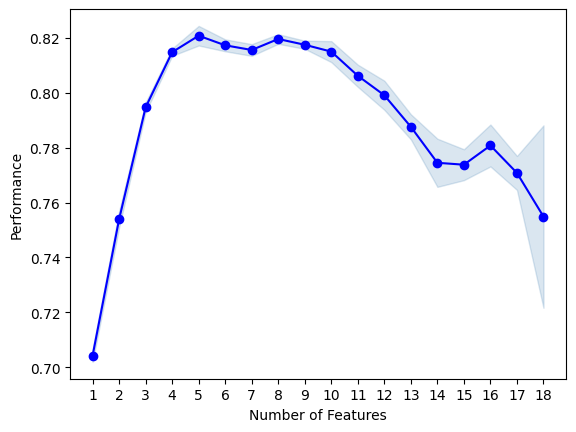

In [40]:
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
#print('all subsets:\n', sfs.subsets_)
plot_sfs(sfs.get_metric_dict(), kind='std_err');

In [39]:
import pandas as pd
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(14,)","[0.7095, 0.705, 0.7025, 0.6965, 0.7075]",0.7042,"(n_bjets,)",0.005799,0.004512,0.002256
2,"(6, 14)","[0.7655, 0.751, 0.749, 0.753, 0.751]",0.7539,"(jet_1_twb, n_bjets)",0.00763,0.005936,0.002968
3,"(6, 7, 14)","[0.797, 0.7965, 0.7905, 0.799, 0.7905]",0.7947,"(jet_1_twb, jet_2_twb, n_bjets)",0.004537,0.00353,0.001765
4,"(6, 7, 8, 14)","[0.8135, 0.814, 0.8125, 0.814, 0.82]",0.8148,"(jet_1_twb, jet_2_twb, jet_3_twb, n_bjets)",0.003415,0.002657,0.001329
5,"(6, 7, 8, 13, 14)","[0.814, 0.832, 0.8245, 0.8125, 0.821]",0.8208,"(jet_1_twb, jet_2_twb, jet_3_twb, n_jets, n_bj...",0.009166,0.007132,0.003566
6,"(3, 6, 7, 8, 13, 14)","[0.813, 0.8125, 0.821, 0.8165, 0.8235]",0.8173,"(jet_1_eta, jet_1_twb, jet_2_twb, jet_3_twb, n...",0.005582,0.004343,0.002171
7,"(3, 6, 7, 8, 13, 14, 15)","[0.821, 0.82, 0.8125, 0.81, 0.8145]",0.8156,"(jet_1_eta, jet_1_twb, jet_2_twb, jet_3_twb, n...",0.005474,0.004259,0.00213
8,"(3, 4, 6, 7, 8, 13, 14, 15)","[0.818, 0.82, 0.8245, 0.814, 0.8215]",0.8196,"(jet_1_eta, jet_2_eta, jet_1_twb, jet_2_twb, j...",0.004515,0.003513,0.001756
9,"(3, 4, 5, 6, 7, 8, 13, 14, 15)","[0.8185, 0.821, 0.82, 0.814, 0.814]",0.8175,"(jet_1_eta, jet_2_eta, jet_3_eta, jet_1_twb, j...",0.003813,0.002966,0.001483
10,"(3, 4, 5, 6, 7, 8, 9, 13, 14, 15)","[0.8075, 0.8205, 0.8065, 0.814, 0.8265]",0.815,"(jet_1_eta, jet_2_eta, jet_3_eta, jet_1_twb, j...",0.009822,0.007642,0.003821


# subset of the dataset

In [ ]:
with h5py.File("info/data/output_signal.h5", "r") as file:
    signal_data = file["events"][:]

with h5py.File("info/data/output_bg.h5", "r") as file:
    bg_data = file["events"][:]


len(signal_data) == 265525 , len(bg_data) == 232503 ## doesnt match the md file

In [ ]:
signal = pd.DataFrame(signal_data)
background = pd.DataFrame(bg_data)
df = pd.concat([signal, background])
df = df.reset_index()
labels = np.concatenate([np.ones(signal.shape[0]), np.zeros(background.shape[0])])
labels = pd.DataFrame({'ttZ': labels})
df = df.join(labels)
df

In [ ]:
subset_df['ttZ']

In [ ]:
preprocessing_layer = K.layers.Normalization()
preprocessing_layer.adapt(subset_df)

In [ ]:
def build_model(input_dim = None):
    model = K.Sequential([
        preprocessing_layer,
        K.layers.Dense(50, activation="relu", input_dim=input_dim),
        K.layers.Dense(25, activation="relu", name="hidden2"),
        K.layers.Dense(10, activation="relu", name="hidden3"),
        K.layers.Dense(1, activation="sigmoid", name="output"),
    ])
    model.compile(
    optimizer=K.optimizers.Adam(learning_rate=0.0002),
    loss=K.losses.BinaryCrossentropy(),
    metrics=[K.metrics.BinaryAccuracy()])
    
    return model


In [ ]:
model = KerasClassifier(build_fn = build_model(input_dim=subset_df.shape[1]), epochs=10, batch_size=32, verbose=1)

In [ ]:


# Create an SFS object
sfs = SFS(model, 
          k_features=1, #(3, 5),  # You can specify a range or a specific number of features
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=0,  
          verbose=2)

In [ ]:
subset_df.shape[1]